In [2]:
from tensorflow.keras.layers import Input, LSTM, GRU,SimpleRNN, Dense, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



In [3]:
# Load the data

akbank_data = pd.read_csv("C:\\Users\\ERALP\\OneDrive\\Desktop\\Software Engineering\\SWE599---Financial-Time-Series-Volatility-and-Return-Forecasting\\Code\\akbank_data.csv")

akbank_data.head()


,Date,Hour,Open,High,Low,Close
0,12/2/2019,9:00:00,6.57,6.57,6.57,6.57
1,12/2/2019,10:00:00,6.57,6.59,6.51,6.52
2,12/2/2019,11:00:00,6.52,6.58,6.51,6.57
3,12/2/2019,12:00:00,6.57,6.57,6.46,6.48
4,12/2/2019,13:00:00,6.49,6.49,6.49,6.49


In [4]:
akbank_data.tail()

,Date,Hour,Open,High,Low,Close
9987,21/02/2023,17:00:00,16.12,16.14,15.80,15.92
9988,21/02/2023,18:00:00,15.90,15.90,15.90,15.90
9989,22/02/2023,9:00:00,15.89,15.89,15.89,15.89
9990,22/02/2023,10:00:00,15.88,16.23,15.82,16.13
9991,22/02/2023,11:00:00,16.13,16.29,16.09,16.17


In [5]:
akbank_data = akbank_data[['Date', 'Hour', 'Open', 'High', 'Low', 'Close']]

#Converting Date and Hour to datetime object and setting it as index. This will help us to plot the data in a time series manner.

akbank_data['Datetime'] = pd.to_datetime(akbank_data['Date'] + " " + akbank_data['Hour'])

#Dropping Date and Hour columns
akbank_data.set_index('Datetime', inplace=True)
akbank_data.drop(['Date', 'Hour'], axis=1, inplace=True)

akbank_data.head()

,Open,High,Low,Close
Datetime,,,,
2019-12-02 09:00:00,6.57,6.57,6.57,6.57
2019-12-02 10:00:00,6.57,6.59,6.51,6.52
2019-12-02 11:00:00,6.52,6.58,6.51,6.57
2019-12-02 12:00:00,6.57,6.57,6.46,6.48
2019-12-02 13:00:00,6.49,6.49,6.49,6.49


In [6]:
akbank_data.tail()

,Open,High,Low,Close
Datetime,,,,
2023-02-21 17:00:00,16.12,16.14,15.80,15.92
2023-02-21 18:00:00,15.90,15.90,15.90,15.90
2023-02-22 09:00:00,15.89,15.89,15.89,15.89
2023-02-22 10:00:00,15.88,16.23,15.82,16.13
2023-02-22 11:00:00,16.13,16.29,16.09,16.17


In [7]:
series = akbank_data['Close'].values.reshape(-1,1)

In [8]:
# Normalize the data

scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()



In [9]:
# Build the dataset
# Let's see if we can use T past values to predict the next value
# In other words, T past values -> single future value

T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)


X.shape (9982, 10, 1) Y.shape (9982,)


In [10]:
# Try autoregressive RNN model

i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# Train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
156/156 [==============================] - 4s 10ms/step - loss: 0.2247 - val_loss: 20.4462
Epoch 2/80
156/156 [==============================] - 1s 7ms/step - loss: 0.0695 - val_loss: 19.2417
Epoch 3/80
156/156 [==============================] - 1s 8ms/step - loss: 0.0290 - val_loss: 18.1947
Epoch 4/80
156/156 [==============================] - 1s 8ms/step - loss: 0.0133 - val_loss: 17.4203
Epoch 5/80
156/156 [==============================] - 1s 9ms/step - loss: 0.0088 - val_loss: 16.9356
Epoch 6/80
156/156 [==============================] - 2s 10ms/step - loss: 0.0069 - val_loss: 16.6373
Epoch 7/80
156/156 [==============================] - 2s 10ms/step - loss: 0.0059 - val_loss: 16.4015
Epoch 8/80
156/156 [==============================] - 2s 12ms/step - loss: 0.0054 - val_loss: 16.2242
Epoch 9/80
156/156 [==============================] - 1s 9ms/step - loss: 0.0050 - val_loss: 16.0981
Epoch 10/80
156/156 [==============================] - 1s 8ms/step - loss: 0.0047 - val

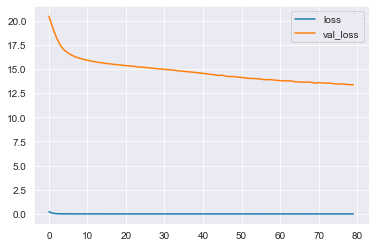

In [11]:
# Plot loss per iteration

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

312/312 [==============================] - 1s 2ms/step
(9982, 1)


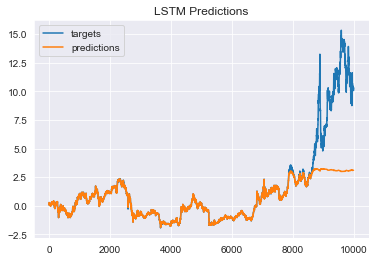

In [12]:
# One-step forecast using true targets

# Note: even the one-step forecast fails badly

outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("LSTM Predictions")
plt.legend()
plt.show()

1/1 [==============================] - 0s 16ms/step


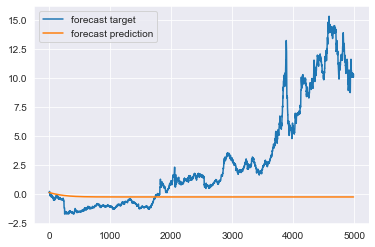

In [13]:
# Multi-step forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()



In [14]:
akbank_data['PrevClose'] = akbank_data['Close'].shift(1)

In [15]:
akbank_data.head()

,Open,High,Low,Close,PrevClose
Datetime,,,,,
2019-12-02 09:00:00,6.57,6.57,6.57,6.57,NaN
2019-12-02 10:00:00,6.57,6.59,6.51,6.52,6.57
2019-12-02 11:00:00,6.52,6.58,6.51,6.57,6.52
2019-12-02 12:00:00,6.57,6.57,6.46,6.48,6.57
2019-12-02 13:00:00,6.49,6.49,6.49,6.49,6.48


In [16]:
# return is 

akbank_data['Return']= (akbank_data['Close']- akbank_data['PrevClose']) / akbank_data['PrevClose']

In [17]:
akbank_data.head()

,Open,High,Low,Close,PrevClose,Return
Datetime,,,,,,
2019-12-02 09:00:00,6.57,6.57,6.57,6.57,NaN,NaN
2019-12-02 10:00:00,6.57,6.59,6.51,6.52,6.57,-0.007610
2019-12-02 11:00:00,6.52,6.58,6.51,6.57,6.52,0.007669
2019-12-02 12:00:00,6.57,6.57,6.46,6.48,6.57,-0.013699
2019-12-02 13:00:00,6.49,6.49,6.49,6.49,6.48,0.001543


<AxesSubplot:>

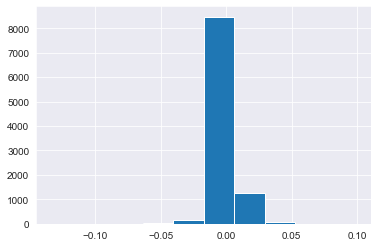

In [18]:
akbank_data['Return'].hist()

In [19]:
series = akbank_data['Return'].values[1:].reshape(-1,1)

scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten()

In [20]:
T = 10

In [21]:
akbank_data.head()

,Open,High,Low,Close,PrevClose,Return
Datetime,,,,,,
2019-12-02 09:00:00,6.57,6.57,6.57,6.57,NaN,NaN
2019-12-02 10:00:00,6.57,6.59,6.51,6.52,6.57,-0.007610
2019-12-02 11:00:00,6.52,6.58,6.51,6.57,6.52,0.007669
2019-12-02 12:00:00,6.57,6.57,6.46,6.48,6.57,-0.013699
2019-12-02 13:00:00,6.49,6.49,6.49,6.49,6.48,0.001543


<AxesSubplot:>

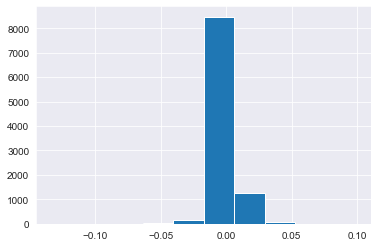

In [22]:
akbank_data['Return'].hist()

In [23]:
series = akbank_data['Return'].values[1:].reshape(-1,1)

scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten()

In [26]:
T = 10
D= 1
X = []
Y = []

for t in range(len(series)-T):
    x= series[t:t+T]
    X.append(x)
    y= series[t-T]
    Y.append(y)
    
X = np.array(X).reshape(-1,T,1)
Y = np.array(Y)
N= len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)


X.shape (9981, 10, 1) Y.shape (9981,)


In [27]:
# Try autoregressive RNN model

i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN

r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)


Epoch 1/80
156/156 [==============================] - 4s 11ms/step - loss: 1.0049 - val_loss: 1.5736
Epoch 2/80
156/156 [==============================] - 1s 8ms/step - loss: 1.0013 - val_loss: 1.5710
Epoch 3/80
156/156 [==============================] - 2s 14ms/step - loss: 1.0006 - val_loss: 1.5721
Epoch 4/80
156/156 [==============================] - 2s 12ms/step - loss: 1.0003 - val_loss: 1.5715
Epoch 5/80
156/156 [==============================] - 1s 9ms/step - loss: 1.0006 - val_loss: 1.5710
Epoch 6/80
156/156 [==============================] - 2s 13ms/step - loss: 1.0001 - val_loss: 1.5710
Epoch 7/80
156/156 [==============================] - 2s 13ms/step - loss: 1.0000 - val_loss: 1.5706
Epoch 8/80
156/156 [==============================] - 2s 12ms/step - loss: 0.9997 - val_loss: 1.5693
Epoch 9/80
156/156 [==============================] - 2s 13ms/step - loss: 0.9995 - val_loss: 1.5700
Epoch 10/80
156/156 [==============================] - 2s 11ms/step - loss: 0.9994 - val_loss

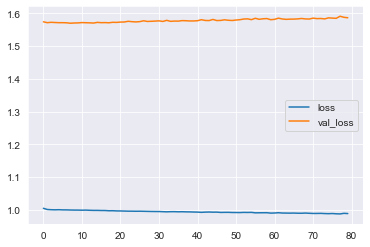

In [28]:
# Plot loss per iteration

import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()


312/312 [==============================] - 2s 3ms/step
(9981, 1)


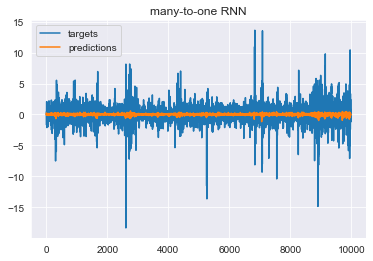

In [29]:
# One-step forecast using true targets

outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("many-to-one RNN")
plt.legend()
plt.show()

1/1 [==============================] - 0s 31ms/step


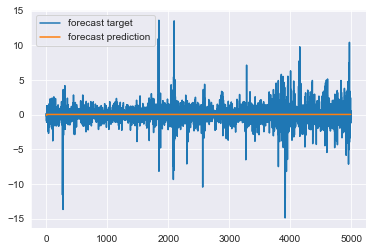

In [30]:
# Multi-step forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()


In [31]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!

input_data = akbank_data[['Open', 'High', 'Low', 'Close']].values
targets = akbank_data['Return'].values



In [32]:
# Now make the actual data which will go into the neural network

T = 10
D = input_data.shape[1]
N = len(input_data) - T

In [33]:
# Normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)


In [34]:
# Setup X_train and Y_train

X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)



In [35]:
# Setup X_test and Y_test

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N-Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [40]:
# Make the RNN

i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(learning_rate=0.001),
  metrics=['accuracy'],
)

In [41]:
# Train the RNN

r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Epoch 1/300
209/209 [==============================] - 6s 10ms/step - loss: 0.6756 - accuracy: 0.5981 - val_loss: 0.7303 - val_accuracy: 0.5384
Epoch 2/300
209/209 [==============================] - 2s 8ms/step - loss: 0.6740 - accuracy: 0.6002 - val_loss: 0.7445 - val_accuracy: 0.5384
Epoch 3/300
209/209 [==============================] - 2s 8ms/step - loss: 0.6734 - accuracy: 0.6013 - val_loss: 0.6931 - val_accuracy: 0.5384
Epoch 4/300
209/209 [==============================] - 2s 8ms/step - loss: 0.6727 - accuracy: 0.6017 - val_loss: 0.7129 - val_accuracy: 0.5384
Epoch 5/300
209/209 [==============================] - 2s 8ms/step - loss: 0.6729 - accuracy: 0.6013 - val_loss: 0.7030 - val_accuracy: 0.5384
Epoch 6/300
209/209 [==============================] - 2s 11ms/step - loss: 0.6726 - accuracy: 0.6013 - val_loss: 0.6925 - val_accuracy: 0.5197
Epoch 7/300
209/209 [==============================] - 2s 12ms/step - loss: 0.6732 - accuracy: 0.6013 - val_loss: 0.6916 - val_accuracy: 0.5

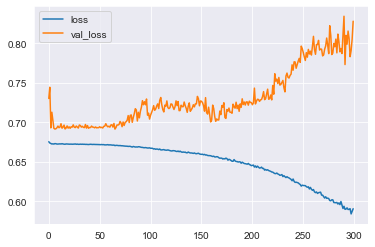

In [42]:
# Plot loss per iteration

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

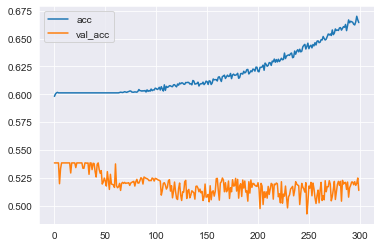

In [43]:
# Plot accuracy per iteration

plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
